<a href="https://colab.research.google.com/github/racheopod/piosfinder/blob/master/predict/PiosphereSearch_WYNAIP2019_piosfinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search for Piospheres in 2019 Wyoming NAIP imagery

Rachel R. Renne

May 9, 2023

This notebook uses Google Earth Engine to access National Agricultural Imagery Program ([NAIP](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-aerial-photography-national-agriculture-imagery-program-naip?qt-science_center_objects=0#qt-science_center_objects)) data in Wyoming. Imagery is exported to Google Drive in tiles corresponding to United States Geological Survey quarter-quads, then chipped into 256x256 images and converted to PNG files. Then a trained neural network is used to predict the presence of piospheres in the chipped images. Positive images are saved in GeoTIFF format to Google Drive.

## (1.) Authenticate to Earth Engine

In [ ]:
!pip install earthengine-api #earth-engine Python API

In [ ]:
!earthengine authenticate

## (2.) Software setup

In [26]:
# Earth Engine Python API
import ee
ee.Initialize()

In [ ]:
# Install libraries
!pip install geetools
!pip install geemap
!pip install imagecodecs
!pip install -q splitraster

In [28]:
# Import other libraries
import numpy as np
import torch
import torchvision.transforms as transforms
import folium
import geemap
from geetools import batch
import imagecodecs
from splitraster import io
from splitraster import geo
import time 
import os
from osgeo import gdal
import splitraster
import json
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Resize, ToTensor
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader

from torchvision.utils import save_image, make_grid
import matplotlib.image as mpimg
from  matplotlib import pyplot as plt
from torchvision.io import read_image
from mpl_toolkits.axes_grid1 import ImageGrid
import torchvision
import yaml

In [29]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## (3.) Import imagery and restrict to 2019 in WY

In [30]:
# Load in states
states = ee.FeatureCollection('TIGER/2018/States')

# Get Wyoming
WY1 = ee.Feature(states.filter('STUSPS == "WY"').first())
wy1 = ee.Algorithms.ProjectionTransform(WY1,'EPSG:26913',0.01)

In [31]:
# Load a landsat image and select three bands.
naipyear = ee.ImageCollection('USDA/NAIP/DOQQ')\
    .filterDate('2019-01-01', '2020-1-01')\
    .filterBounds(wy1.geometry())\
    .select('N','R','G')

In [32]:
# Check number of images (7421)
imgcount = naipyear.size().getInfo()
print(imgcount)

7421


## (4.) Create some functions for working with images

In [33]:
# Function to convert geotiff to png as object
def geotiff_to_png(input_path, output_path=None, return_object=False):

  '''
  Converts a GeoTIFF file to a PNG file or object

  Args:
    input_path (str): The file path of the input GeoTIFF file.
    output_path (str, optional): The file path of the output PNG file. If not provided, PNG object is returned. Defaults to None.
    return_object (bool, optional): Whether to return the PNG data as an object. If True, the output_path parameter will be ignored. Defaults to False.

  Returns:
    numpy.ndarray or None: If output_path is not provided and return_object is True, returns a 3D numpy array representing the PNG image. Otherwise, returns None.
  '''

  # Open input file
  dataset = gdal.Open(input_path)
  output_types = [gdal.GDT_Byte, gdal.GDT_UInt16, gdal.GDT_Float32]

  # Define output format and options
  options = gdal.TranslateOptions(format='PNG', bandList=[1,2,3], creationOptions=['WORLDFILE=YES'], outputType=output_types[0])

  # Translate to PNG
  if output_path is not None:
    gdal.Translate(output_path, dataset, options=options)
    print(f'Successfully saved PNG file to {output_path}')

  # Return PNG object
  if return_object:
    mem_driver = gdal.GetDriverByName('MEM')
    mem_dataset = mem_driver.CreateCopy('', dataset, 0)
    png_data = mem_dataset.ReadAsArray()
    return png_data

In [34]:
# Create a prediction dataset class
class NAIPPredictDataset(Dataset):

    LABEL_CLASSES = {
        'None': 0,
        'Piosphere': 1
    }

    def __init__(self, data_root):
        '''
            Pull in data from Google Drive folder and prepare for prediction.
        '''
        self.data_root = data_root
        self.transform = Compose([ToTensor()])
        
        # index data into list
        self.data = []

        # Get list of files from Google Drive folder
        images = os.listdir(data_root)

        # Put all images into data
        for i in images:
            imgFileName = i
            self.data.append([imgFileName, imgFileName]) # image name and 2 for no class
        print("Total images in this quad: "+str(len(self.data)))

    def __len__(self):
        '''
            Returns the length of the dataset.
        '''
        return len(self.data)

    
    def __getitem__(self, idx):
        '''
            Returns a single data point at given idx.
            Here's where we actually load the image.
        '''
        image_name, label = self.data[idx]
        
        # load image
        image_path = os.path.join(self.data_root, image_name)
        # img = Image.open(image_path)

        # transform: geotiff to png, png to tensor
        img_png = geotiff_to_png(image_path, output_path=None, return_object=True)
        img_tensor1 = self.transform(img_png)
        img_tensor = img_tensor1.permute(1,0,2)

        return img_tensor, label


In [35]:
# Define a function to create the dataloader
def create_predictdataloader(save_path):
    '''
        Loads a dataset for prediction and PyTorch DataLoader object.
    '''
    dataset_instance = NAIPPredictDataset(save_path)        # create an object instance of NAIPDataset class

    dataLoader = DataLoader(
            dataset=dataset_instance,
            batch_size=32,
            shuffle=False,
            num_workers=2
        )
    return dataLoader

In [36]:
# Little function to display grids of images
def show(img, title, figsize=(16,10)):
    npimg = img.numpy()
    
    plt.figure(figsize = figsize)
    plt.title(title)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', aspect = 'auto')

## (5.) Export imagery to Google Drive and predict

In [15]:
# Run the model file (contains ResNet and ResidualBlock classes)
%run /content/drive/MyDrive/trained_models/first_run_model
# config = 'model_states/config.yaml'
config = '/content/drive/MyDrive/trained_models/config.yaml'

# load config
print(f'Using config "{config}"')
cfg = yaml.safe_load(open(config, 'r'))

# Set device
device = 'cuda'

Using config "/content/drive/MyDrive/trained_models/config.yaml"


In [16]:
# Make a list of images (start with 2 to try)
naip2 = naipyear.limit(2)
imageList = naip2.toList(naip2.size())
#imagesList = naipyear.toList(naipyear.size())
# Double check number of images
nimg = imageList.size().getInfo()
nimg

2

In [ ]:
# Loop through imageList and export each quarter quad to drive
for i in range(0,1):#6264, nimg):
  # Get ith image
  image= ee.Image(imageList.get(i))

  # Get image ID for filename
  imgid = image.id().getInfo()

  # Set up export task
  task = batch.Export.image.toDrive(
      image = "thisquarterquad",
      folder = "NAIP2019_quads",
      fileNamePrefix = "currentquad",
      scale = 0.6,
      maxPixels = int(1e13))
  task.start()

  # Provide updates each minute export is running (often takes 15-20 minutes)
  while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(60)
  
  # Reload image and split into tiles
  input_image_path = "/content/drive/MyDrive/NAIP2019_quads/thisquarterquad.tif"

  save_path = "/content/drive/MyDrive/NAIP2019_tiles"
  crop_size = 256
  repetition_rate = 0
  overwrite = True

  # Split the quad into image chips (256x256 pixels)
  n = geo.split_image(input_image_path, save_path, crop_size,
                     repetition_rate=repetition_rate, overwrite=overwrite)
  print(f"{n} tiles sample of {input_image_path} are added at {save_path}")

  # Create training dataloader for this new data
  dl_predict = create_predictdataloader(save_path)

  # load model
  model = ResNet(ResidualBlock, [3, 4, 6, 3])
  model.load_state_dict(torch.load('/content/drive/MyDrive/trained_models/92.pt')['model'])

  # Put model on device
  model.to(device)

  # Loop through and collect positive identifications
  positive_images = []
  positive_ids = []
  for idx, (data, labels) in enumerate(dl_predict):  
      # truelabs.append(labels)

      # Evaluate model (?)
      model.eval()

      # Predict
      prediction = model(data)

      # Convert to predictions:
      preds = prediction.argmax(dim=1)

      # Pull out positive predictions
      for pred, img in zip(preds, data):
          if pred == 1:
            positive_images.append(img)
            positive_ids.append(labels)
          else:
            continue
  
  # Move positive images to positive image folder and add quarter quad name to filename
  origin = "/content/drive/MyDrive/NAIP2019_tiles/"
  final_save_path = '/content/drive/MyDrive/NAIP2019_positive_images/'
  for q in positive_ids:
    os.rename(origin + q, final_save_path + imgid + "_" + q)
  # Count and report number of positive images
  print(f"{len(positive_images)} positive tiles were added to {final_save_path}")


0


## (6.) Run through a trial with last quad processed to Drive

*Requires that (.5) was already run at least once.*



In [37]:
# Create training dataloader with transformations implemented
save_path = "/content/drive/MyDrive/NAIP2019_tiles"
dl_predict = create_predictdataloader(save_path)

# Get image ID from current quad
imgid = os.listdir("/content/drive/MyDrive/NAIP2019_quads")[0]

Total images in this quad: 1776


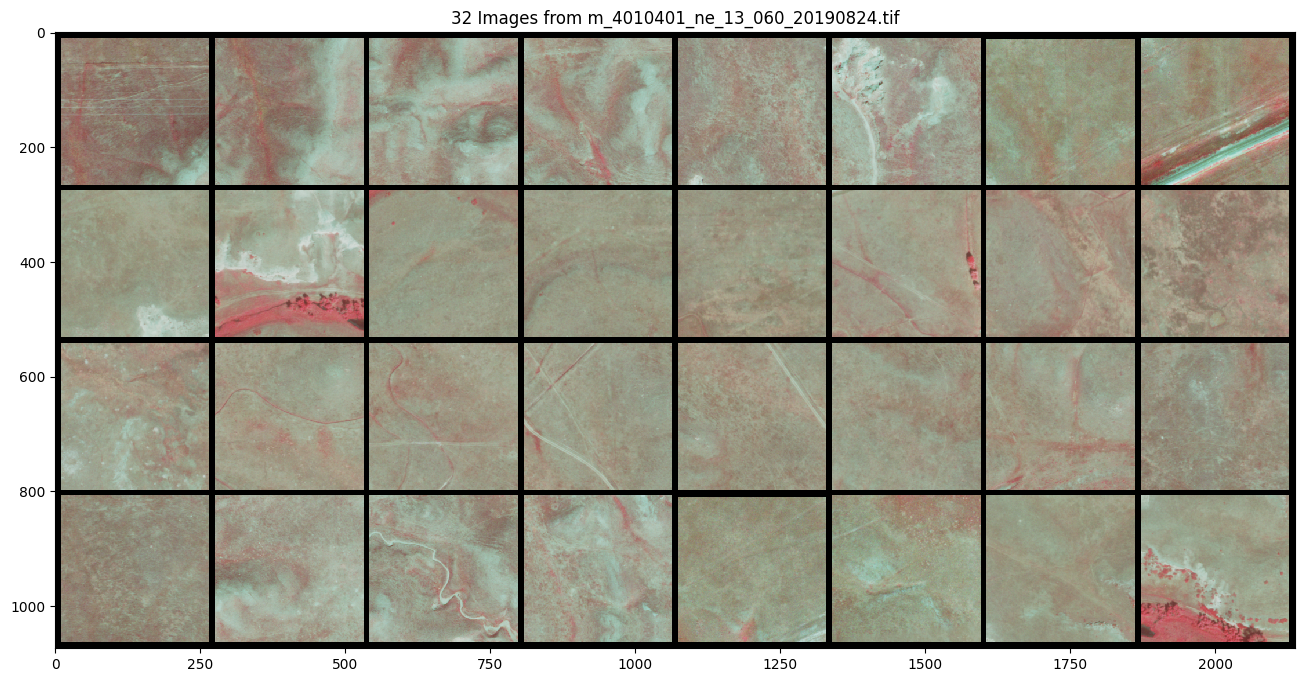

In [38]:
# Look at some images from this quad
data, labels = next(iter(dl_predict))

grid = torchvision.utils.make_grid(data, nrow=8, padding=10)
show(grid, "32 Images from "+ imgid, (16,8))

In [40]:
# Run the model file (contains ResNet and ResidualBlock classes)
%run /content/drive/MyDrive/trained_models/first_run_model
# config = 'model_states/config.yaml'
config = '/content/drive/MyDrive/trained_models/config.yaml'

# load config
print(f'Using config "{config}"')
cfg = yaml.safe_load(open(config, 'r'))

Using config "/content/drive/MyDrive/trained_models/config.yaml"


In [42]:
# load model
model = ResNet(ResidualBlock, [3, 4, 6, 3])
model.load_state_dict(torch.load('/content/drive/MyDrive/trained_models/92.pt', map_location=torch.device('cpu'))['model'])

<All keys matched successfully>

In [43]:
# Confirm model is on device
device = 'cpu'
model.to(device)

# Put model in eval mode
model.eval()

# Predict
prediction = model(data)

# Convert to predictions:
preds = prediction.argmax(dim=1)

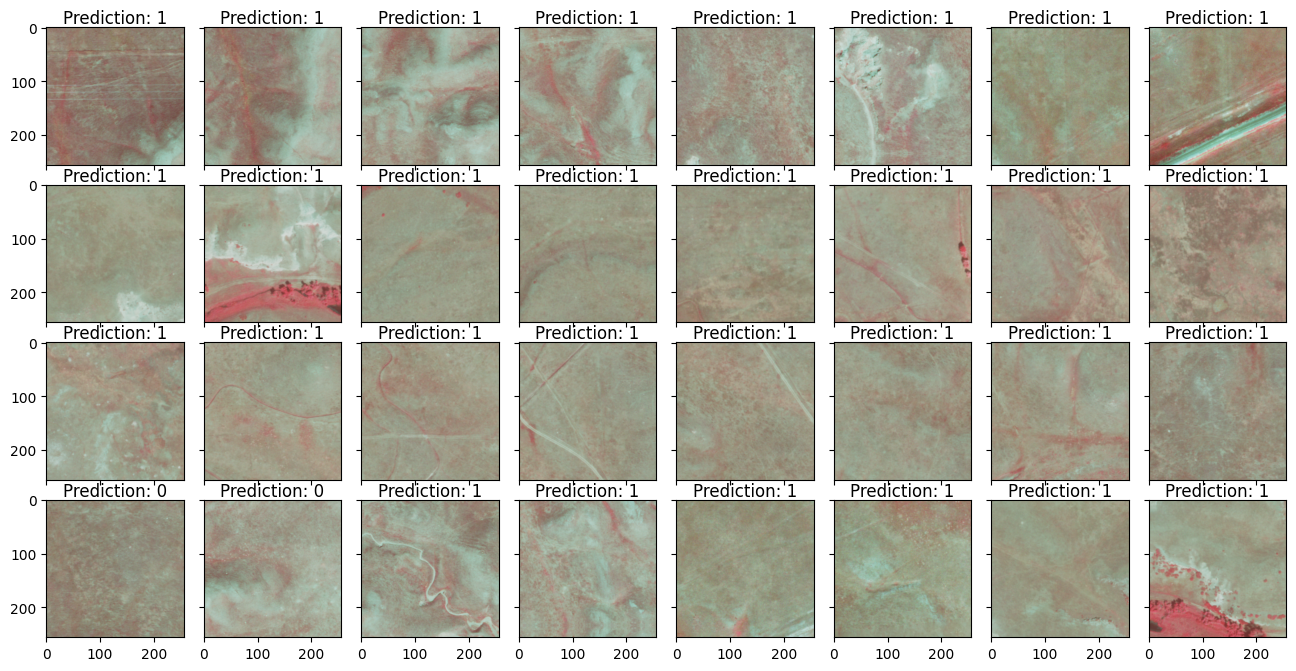

In [44]:
# Visualize predictions
fig = plt.figure(figsize=(16., 32.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )

for ax, im, pred in zip(grid, data, preds):
    im = torchvision.transforms.ToPILImage()(im)
    # pred = pred.detach().numpy()
    # Iterating over the grid returns the Axes.
    ax.set_title("Prediction: " + str(pred.item()), pad = 3)
    ax.imshow(im)

plt.show()

In [45]:
# Loop through and collect positive identifications
positive_images = []
positive_ids = []
for idx, (data, labels) in enumerate(dl_predict):  
    # truelabs.append(labels)

    # Evaluate model (?)
    model.eval()

    # Predict
    prediction = model(data)

    # Convert to predictions:
    preds = prediction.argmax(dim=1)

    # Pull out positive predictions
    for pred, img, lb in zip(preds, data, labels):
        if pred == 1:
            positive_images.append(img)
            positive_ids.append(lb)
        else:
            continue

In [46]:
len(positive_ids)

1575

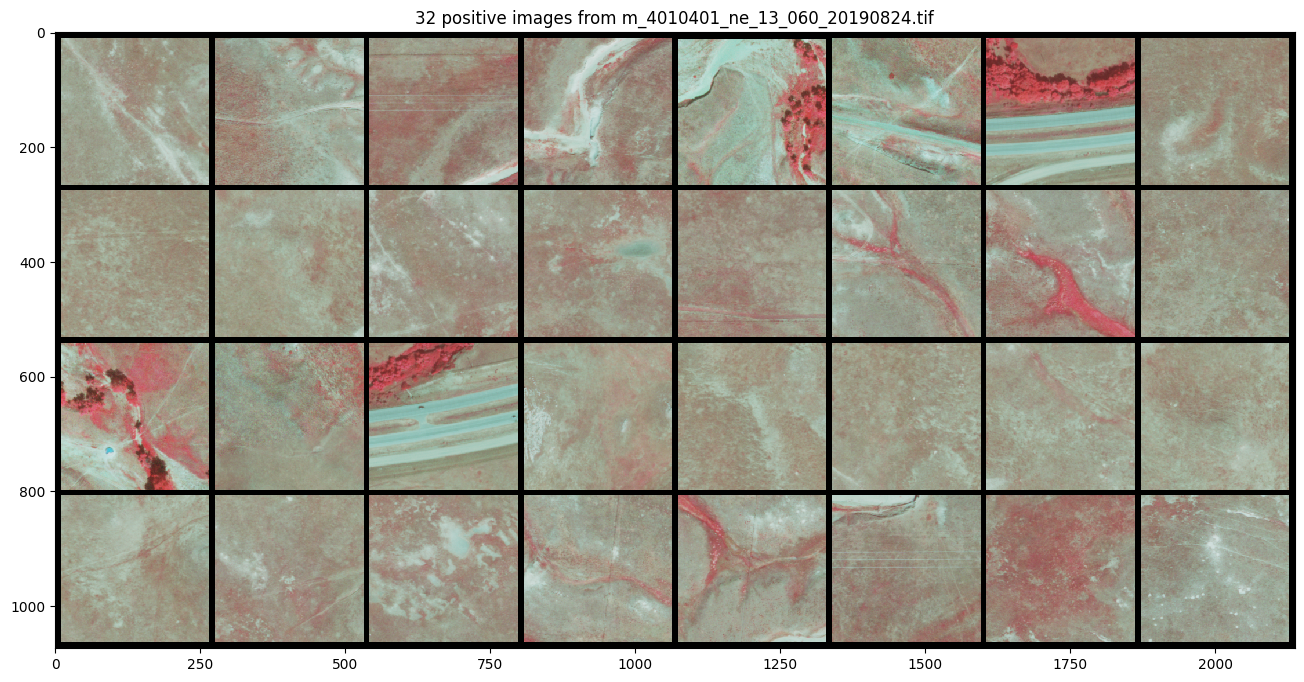

In [58]:
# Look at some of these many positive images
grid = torchvision.utils.make_grid(positive_images[1333:1365:1], nrow=8, padding=10)
show(grid, "32 positive images from "+ imgid, (16,8))

In [ ]:
# Move positive images to positive image folder and add quarter quad name to filename
origin = "/content/drive/MyDrive/NAIP2019_tiles/"
final_save_path = '/content/drive/MyDrive/NAIP2019_positive_images/'
for q in positive_ids:
  os.rename(origin + q, final_save_path + imgid + "_" + q)
# Count and report number of positive images
print(f"{len(positive_images)} positive tiles were added to {final_save_path}")

1252 positive tiles were added to /content/drive/MyDrive/NAIP2019_positive_images/


In [ ]:
# Undo move if needed
origin = "/content/drive/MyDrive/NAIP2019_tiles/"
final_save_path = '/content/drive/MyDrive/NAIP2019_positive_images/'
for q in np.array(os.listdir(final_save_path)):
  # print(q.replace(imgid + "_",""))
  os.rename(final_save_path+q, origin + q.replace(imgid + "_",""))